In [8]:
import pandas as pd

# If downloaded manually:
# df = pd.read_csv("data/pima-indians-diabetes.csv")




df = pd.read_csv("diabetes.csv")
print(df.shape)
df.head()


(768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [2]:
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [3]:
import numpy as np

# Columns where zero means “missing”
missing_cols = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

df[missing_cols] = df[missing_cols].replace(0, np.nan)
df.isna().sum()


Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Replace impossible zeros with NaN
missing_cols = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
df[missing_cols] = df[missing_cols].replace(0, np.nan)

# Flag high-missingness columns
df["Missing_Insulin"] = df["Insulin"].isna().astype(int)
df["Missing_Skin"] = df["SkinThickness"].isna().astype(int)

# Impute with median
df[missing_cols] = df[missing_cols].fillna(df[missing_cols].median())

# ----------------------------------
# Split into two groups: young vs old
# ----------------------------------
age_threshold = df["Age"].median()  # roughly 29 years in this dataset
mask_young = df["Age"] < age_threshold
mask_old = ~mask_young

X_young = df.loc[mask_young].drop(columns="Outcome")
y_young = df.loc[mask_young, "Outcome"]

X_old = df.loc[mask_old].drop(columns="Outcome")
y_old = df.loc[mask_old, "Outcome"]

print(f"Young group: {X_young.shape}, Old group: {X_old.shape}")

# ----------------------------------
# Scale each group using same scaler (fit on combined data for fairness)
# ----------------------------------
scaler = StandardScaler()
scaler.fit(pd.concat([X_young, X_old], axis=0))

X_young_scaled = scaler.transform(X_young)
X_old_scaled = scaler.transform(X_old)


Young group: (367, 10), Old group: (401, 10)


In [9]:
import os, sys
# Removed old path hack; using package imports, "../..")))

from llm_prior_project.data.llm_ensemble_utils import (
    make_default_models,
    run_ensemble_experiment,
    alpha_sweep
)


In [12]:
models = make_default_models()


In [13]:
weights_young2old, metrics_young2old = run_ensemble_experiment(
    X_young_scaled, y_young,   # train on young
    X_old_scaled, y_old,       # test on old
    models,
    use_optimizer=True  # default, but explicit
)

print("=== Train on YOUNG → Test on OLD ===")
print("Optimized weights:", np.round(weights_young2old, 3))
print("Performance metrics:", metrics_young2old)


=== Train on YOUNG → Test on OLD ===
Optimized weights: [1. 0. 0.]
Performance metrics: {'accuracy': 0.683291770573566, 'auc': 0.7580123419926347, 'logloss': 0.6120347593785461}


In [15]:
weights_old2young, metrics_old2young = run_ensemble_experiment(
    X_old_scaled, y_old,       # train on old
    X_young_scaled, y_young,   # test on young
    models
)

print("\n=== Train on OLD → Test on YOUNG ===")
print("Optimized weights:", np.round(weights_old2young, 3))
print("Performance metrics:", metrics_old2young)



=== Train on OLD → Test on YOUNG ===
Optimized weights: [0.337 0.663 0.   ]
Performance metrics: {'accuracy': 0.8119891008174387, 'auc': 0.827655119908641, 'logloss': 0.430963464727771}


In [16]:
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss

print("\n=== Baseline Models (Train on Young → Test on Old) ===")
for m, name in zip(models, ["LogReg", "RF", "GB"]):
    p = m.predict_proba(X_old_scaled)[:, 1]
    print(f"{name:7s}  AUC={roc_auc_score(y_old, p):.3f}  "
          f"Acc={accuracy_score(y_old, (p>=0.5)):.3f}  "
          f"LogLoss={log_loss(y_old, p):.3f}")



=== Baseline Models (Train on Young → Test on Old) ===
LogReg   AUC=0.796  Acc=0.716  LogLoss=0.554
RF       AUC=0.973  Acc=0.918  LogLoss=0.271
GB       AUC=0.940  Acc=0.878  LogLoss=0.339


In [17]:
print("\n=== Baseline Models (Train on Old → Test on Young) ===")
for m, name in zip(models, ["LogReg", "RF", "GB"]):
    p = m.predict_proba(X_young_scaled)[:, 1]
    print(f"{name:7s}  AUC={roc_auc_score(y_young, p):.3f}  "
          f"Acc={accuracy_score(y_young, (p>=0.5)):.3f}  "
          f"LogLoss={log_loss(y_young, p):.3f}")



=== Baseline Models (Train on Old → Test on Young) ===
LogReg   AUC=0.848  Acc=0.807  LogLoss=0.446
RF       AUC=0.802  Acc=0.809  LogLoss=0.435
GB       AUC=0.800  Acc=0.787  LogLoss=0.415


In [19]:
import numpy as np
import pandas as pd

# ---------------------------------------------------------
# 1. Example placeholder LLM-style coefficients
# (You’ll later replace these with LLM outputs)
# ---------------------------------------------------------
llm_betas_young = np.array([
    0.12,   # Pregnancies
    1.35,   # Glucose
    0.06,   # BloodPressure
    0.04,   # SkinThickness
    0.28,   # Insulin
    0.55,   # BMI
    0.48,   # DiabetesPedigreeFunction
    0.12,   # Age
    0.07,   # Missing_Insulin
    0.02    # Missing_Skin
])
llm_beta0_young = -2.2

llm_betas_old = np.array([
    0.06,   # Pregnancies
    1.35,   # Glucose
    0.28,   # BloodPressure
    0.18,   # SkinThickness
    0.22,   # Insulin
    0.62,   # BMI
    0.42,   # DiabetesPedigreeFunction
    0.85,   # Age
    0.10,   # Missing_Insulin
    0.03    # Missing_Skin
])
llm_beta0_old = -0.15



# ---------------------------------------------------------
# 2. Define alpha grid for sweep
# ---------------------------------------------------------
alphas = np.linspace(0.0, 1, 12)

# ---------------------------------------------------------
# 3. Train on YOUNG → Test on OLD
# ---------------------------------------------------------
print("=== Alpha Sweep: Train on YOUNG → Test on OLD ===")
results_y2o = alpha_sweep(
    X_young_scaled, y_young,
    X_old_scaled, y_old,
    models,
    llm_betas_old,       # LLM coefficients informed by OLD group
    llm_beta0_old,
    alpha_values=alphas,
    l2=1e-6
)

df_y2o = pd.DataFrame(results_y2o)
print(df_y2o[["alpha", "metrics"]].head())


# ---------------------------------------------------------
# 4. Train on OLD → Test on YOUNG
# ---------------------------------------------------------
print("\n=== Alpha Sweep: Train on OLD → Test on YOUNG ===")
results_o2y = alpha_sweep(
    X_old_scaled, y_old,
    X_young_scaled, y_young,
    models,
    llm_betas_young,     # LLM coefficients informed by YOUNG group
    llm_beta0_young,
    alpha_values=alphas,
    l2=1e-6
)

df_o2y = pd.DataFrame(results_o2y)
print(df_o2y[["alpha", "metrics"]].head())


=== Alpha Sweep: Train on YOUNG → Test on OLD ===
      alpha                                            metrics
0  0.000000  {'accuracy': 0.7057356608478803, 'auc': 0.7602...
1  0.090909  {'accuracy': 0.6807980049875312, 'auc': 0.7608...
2  0.181818  {'accuracy': 0.6807980049875312, 'auc': 0.7628...
3  0.272727  {'accuracy': 0.6783042394014963, 'auc': 0.7628...
4  0.363636  {'accuracy': 0.6882793017456359, 'auc': 0.7631...

=== Alpha Sweep: Train on OLD → Test on YOUNG ===
      alpha                                            metrics
0  0.000000  {'accuracy': 0.8119891008174387, 'auc': 0.8276...
1  0.090909  {'accuracy': 0.8201634877384196, 'auc': 0.8267...
2  0.181818  {'accuracy': 0.8365122615803815, 'auc': 0.8237...
3  0.272727  {'accuracy': 0.8392370572207084, 'auc': 0.8208...
4  0.363636  {'accuracy': 0.8474114441416893, 'auc': 0.8180...


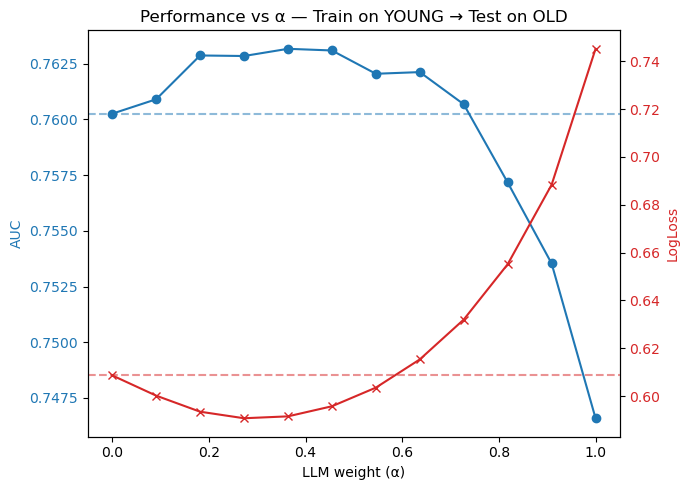

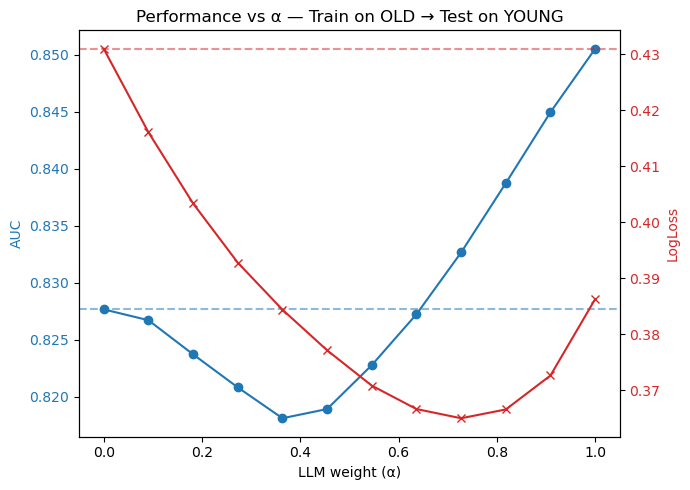

In [20]:
import matplotlib.pyplot as plt

def plot_alpha_sweep(df, title):
    # df is the DataFrame returned by alpha_sweep()
    df = df.copy()
    df["auc"] = df["metrics"].apply(lambda m: m["auc"])
    df["logloss"] = df["metrics"].apply(lambda m: m["logloss"])

    # Baseline = α=0 row
    base_auc = df.loc[df["alpha"] == 0, "auc"].values[0]
    base_log = df.loc[df["alpha"] == 0, "logloss"].values[0]

    fig, ax1 = plt.subplots(figsize=(7,5))

    color1 = "tab:blue"
    ax1.set_xlabel("LLM weight (α)")
    ax1.set_ylabel("AUC", color=color1)
    ax1.plot(df["alpha"], df["auc"], color=color1, marker="o", label="AUC")
    ax1.axhline(base_auc, color=color1, linestyle="--", alpha=0.5, label="Baseline AUC")
    ax1.tick_params(axis="y", labelcolor=color1)

    ax2 = ax1.twinx()
    color2 = "tab:red"
    ax2.set_ylabel("LogLoss", color=color2)
    ax2.plot(df["alpha"], df["logloss"], color=color2, marker="x", label="LogLoss")
    ax2.axhline(base_log, color=color2, linestyle="--", alpha=0.5, label="Baseline LogLoss")
    ax2.tick_params(axis="y", labelcolor=color2)

    plt.title(f"Performance vs α — {title}")
    plt.tight_layout()
    plt.show()

# Plot both directions
plot_alpha_sweep(df_y2o, "Train on YOUNG → Test on OLD")
plot_alpha_sweep(df_o2y, "Train on OLD → Test on YOUNG")


In [41]:
def make_default_models(seed=None):
    from sklearn.linear_model import LogisticRegression
    from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
    from sklearn.pipeline import make_pipeline
    from sklearn.preprocessing import StandardScaler
    import numpy as np
    
    if seed is None:
        seed = np.random.randint(0, 10_000)
    return [
        make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, random_state=seed)),
        RandomForestClassifier(n_estimators=200, random_state=seed),
        GradientBoostingClassifier(random_state=seed)
    ]


In [36]:
# ============================================================================
# UPDATED: causality_utils.py with missing indicators
# ============================================================================

import numpy as np

def get_llm_causality_scores(feature_names):
    """
    Get causality scores for each feature from LLM.
    Returns dict: {feature_name: causality_score}
    
    Causality score interpretation:
    0.9-1.0: Strong causal (direct biological mechanism)
    0.7-0.9: Moderate causal (indirect mechanism)
    0.5-0.7: Weak causal/mixed
    0.0-0.5: Primarily correlational
    """
    causality_scores = {
        # Original features
        'Pregnancies': 0.35,              # Correlational (proxy for hormonal history)
        'Glucose': 0.95,                   # CAUSAL (direct diabetes marker)
        'BloodPressure': 0.40,             # Correlational (comorbidity, not cause)
        'SkinThickness': 0.20,             # Correlational (proxy for obesity)
        'Insulin': 0.90,                   # CAUSAL (direct metabolic marker)
        'BMI': 0.75,                       # CAUSAL (metabolic mechanism)
        'DiabetesPedigreeFunction': 0.85,  # CAUSAL (genetic mechanism)
        'Age': 0.30,                       # Correlational (proxy for cumulative risk)
        
        # Missing indicators - these are purely correlational
        # (missing data patterns reflect measurement practices, not biology)
        'Missing_Insulin': 0.10,           # Correlational (measurement artifact)
        'Missing_Skin': 0.10,              # Correlational (measurement artifact)
    }
    
    # Only return scores for features that exist in feature_names
    return {name: causality_scores.get(name, 0.5) for name in feature_names}


def apply_causality_filter(X, feature_names, causality_threshold=0.7):
    """
    Filter to only causal features (score >= threshold).
    
    Parameters:
    -----------
    X : array, shape (n_samples, n_features)
    feature_names : list of str
        Names of features in X (must match X.shape[1])
    causality_threshold : float
        Minimum causality score to keep feature (default 0.7)
    
    Returns:
    --------
    X_filtered : array with only causal features
    causal_indices : indices of kept features
    causal_features : names of kept features
    """
    # Ensure feature_names matches X dimensions
    if len(feature_names) != X.shape[1]:
        raise ValueError(f"feature_names length ({len(feature_names)}) "
                        f"doesn't match X.shape[1] ({X.shape[1]})")
    
    scores = get_llm_causality_scores(feature_names)
    causal_indices = [i for i, name in enumerate(feature_names) 
                     if scores[name] >= causality_threshold]
    causal_features = [feature_names[i] for i in causal_indices]
    
    X_filtered = X[:, causal_indices]
    
    print(f"    Filtered from {len(feature_names)} to {len(causal_features)} features")
    print(f"    Kept: {causal_features}")
    print(f"    Removed: {[name for name in feature_names if name not in causal_features]}")
    
    return X_filtered, causal_indices, causal_features


def apply_causality_weighting(X, feature_names, weighting_power=1.0):
    """
    Weight features by their causality scores.
    
    Parameters:
    -----------
    X : array, shape (n_samples, n_features)
    feature_names : list of str
        Names of features in X (must match X.shape[1])
    weighting_power : float
        Controls strength of weighting
        1.0 = linear weighting
        2.0 = quadratic (emphasize causal more)
        0.5 = sqrt (gentle weighting)
    
    Returns:
    --------
    X_weighted : array with features scaled by causality
    weights : array of causality weights applied
    """
    # Ensure feature_names matches X dimensions
    if len(feature_names) != X.shape[1]:
        raise ValueError(f"feature_names length ({len(feature_names)}) "
                        f"doesn't match X.shape[1] ({X.shape[1]})")
    
    scores = get_llm_causality_scores(feature_names)
    weights = np.array([scores[name]**weighting_power for name in feature_names])
    
    # Broadcasting: weights shape (n_features,) will broadcast with X shape (n_samples, n_features)
    X_weighted = X * weights[np.newaxis, :]  # Explicit broadcasting
    
    return X_weighted, weights


def get_causal_llm_beta(llm_beta, feature_names, causality_threshold=0.7):
    """
    Extract LLM coefficients for only causal features.
    
    Parameters:
    -----------
    llm_beta : list or array
        LLM coefficients (must match feature_names length)
    feature_names : list of str
    causality_threshold : float
        Minimum causality score to keep feature
    
    Returns:
    --------
    llm_beta_causal : coefficients for causal features only
    causal_indices : which features were kept
    """
    if len(llm_beta) != len(feature_names):
        raise ValueError(f"llm_beta length ({len(llm_beta)}) "
                        f"doesn't match feature_names length ({len(feature_names)})")
    
    scores = get_llm_causality_scores(feature_names)
    causal_indices = [i for i, name in enumerate(feature_names) 
                     if scores[name] >= causality_threshold]
    
    llm_beta_causal = [llm_beta[i] for i in causal_indices]
    
    return llm_beta_causal, causal_indices


def print_causality_summary(feature_names):
    """
    Print a nice summary of causality scores for all features.
    """
    scores = get_llm_causality_scores(feature_names)
    
    print("\n" + "="*80)
    print("LLM-DERIVED CAUSALITY SCORES")
    print("="*80)
    print(f"\n{'Feature':<30} {'Score':<8} {'Category':<20} {'Robustness'}")
    print("-"*80)
    
    for name in feature_names:
        score = scores[name]
        
        if score >= 0.9:
            category = "STRONG CAUSAL"
            robustness = "Universal"
        elif score >= 0.7:
            category = "MODERATE CAUSAL"
            robustness = "High"
        elif score >= 0.5:
            category = "WEAK CAUSAL"
            robustness = "Medium"
        else:
            category = "CORRELATIONAL"
            robustness = "Context-dependent"
        
        print(f"{name:<30} {score:<8.2f} {category:<20} {robustness}")
    
    # Summary stats
    causal_count = sum(1 for s in scores.values() if s >= 0.7)
    correlational_count = len(scores) - causal_count
    
    print("-"*80)
    print(f"Total features: {len(feature_names)}")
    print(f"Causal (≥0.7): {causal_count} features")
    print(f"Correlational (<0.7): {correlational_count} features")
    print("="*80)

In [38]:
# ============================================================================
# MAIN EXPERIMENT: Compare Causality Strategies
# ============================================================================

import numpy as np
import pandas as pd

print("="*80)
print("CAUSALITY EXPERIMENT: Impact on Domain Shift Robustness")
print("="*80)

# Feature names
feature_names = [
    'Pregnancies', 
    'Glucose', 
    'BloodPressure', 
    'SkinThickness',
    'Insulin', 
    'BMI', 
    'DiabetesPedigreeFunction', 
    'Age',
    'Missing_Insulin',    # ← Added
    'Missing_Skin'        # ← Added
]

# Display causality scores
causality_scores = get_llm_causality_scores(feature_names)
print("\nLLM-derived Causality Scores:")
print("-"*80)
for name in feature_names:
    score = causality_scores[name]
    cat = "CAUSAL" if score >= 0.7 else "CORRELATIONAL"
    print(f"  {name:30s}: {score:.2f}  [{cat}]")

# ============================================================================
# Three Strategies to Test
# ============================================================================

strategies = {
    'baseline': {
        'name': 'Baseline (All Features)',
        'description': 'Use all 8 features, no causality filtering'
    },
    'causal_filter': {
        'name': 'Causal Filter (Threshold=0.7)',
        'description': 'Use only features with causality ≥ 0.7'
    },
    'causal_weighting': {
        'name': 'Causality Weighting (Power=1.0)',
        'description': 'Weight all features by causality score'
    }
}

# Domain shift scenarios
scenarios = [
    {
        'name': 'YOUNG→OLD',
        'X_train': X_young_scaled,
        'y_train': y_young,
        'X_test': X_old_scaled,
        'y_test': y_old,
        'llm_beta': llm_betas_old,
        'llm_beta0': llm_beta0_old
    },
    {
        'name': 'OLD→YOUNG',
        'X_train': X_old_scaled,
        'y_train': y_old,
        'X_test': X_young_scaled,
        'y_test': y_young,
        'llm_beta': llm_betas_young,
        'llm_beta0': llm_beta0_young
    }
]

# Storage for results
all_results = []

# ============================================================================
# Run Experiments
# ============================================================================

for scenario in scenarios:
    print(f"\n{'='*80}")
    print(f"SCENARIO: {scenario['name']}")
    print(f"{'='*80}")
    
    X_train = scenario['X_train']
    y_train = scenario['y_train']
    X_test = scenario['X_test']
    y_test = scenario['y_test']
    llm_beta = scenario['llm_beta']
    llm_beta0 = scenario['llm_beta0']
    
    # -------------------------------------------------------------------------
    # STRATEGY 1: Baseline (All Features, No Causality)
    # -------------------------------------------------------------------------
    print(f"\n[Strategy 1] Baseline - All Features")
    
    models_baseline = make_default_models()
    weights_baseline, metrics_baseline = run_ensemble_experiment(
        X_train, y_train, X_test, y_test,
        models_baseline,
        llm_beta=llm_beta,
        llm_beta0=llm_beta0,
        beta_scale=1.0,
        use_optimizer=True,
        fixed_weight=(3, 0.5),  # 50% LLM
        l2=1e-6
    )
    
    print(f"  AUC: {metrics_baseline['auc']:.4f}")
    print(f"  Accuracy: {metrics_baseline['accuracy']:.4f}")
    print(f"  LogLoss: {metrics_baseline['logloss']:.4f}")
    
    all_results.append({
        'Scenario': scenario['name'],
        'Strategy': 'Baseline',
        'Num_Features': 8,
        'AUC': metrics_baseline['auc'],
        'Accuracy': metrics_baseline['accuracy'],
        'LogLoss': metrics_baseline['logloss']
    })
    
    # -------------------------------------------------------------------------
    # STRATEGY 2: Causal Filter (Only High-Causality Features)
    # -------------------------------------------------------------------------
    print(f"\n[Strategy 2] Causal Filter - Only Causal Features")
    
    # Filter training data
    X_train_causal, causal_idx, causal_feats = apply_causality_filter(
        X_train, feature_names, causality_threshold=0.7
    )
    X_test_causal = X_test[:, causal_idx]
    
    # Filter LLM beta
    llm_beta_causal, _ = get_causal_llm_beta(
        llm_beta, feature_names, causality_threshold=0.7
    )
    
    print(f"  Using {len(causal_feats)} causal features: {causal_feats}")
    
    models_causal = make_default_models()
    weights_causal, metrics_causal = run_ensemble_experiment(
        X_train_causal, y_train, X_test_causal, y_test,
        models_causal,
        llm_beta=llm_beta_causal,
        llm_beta0=llm_beta0,
        beta_scale=1.0,
        use_optimizer=True,
        fixed_weight=(3, 0.5),  # 50% LLM
        l2=1e-6
    )
    
    print(f"  AUC: {metrics_causal['auc']:.4f}  ({metrics_causal['auc']-metrics_baseline['auc']:+.4f})")
    print(f"  Accuracy: {metrics_causal['accuracy']:.4f}  ({metrics_causal['accuracy']-metrics_baseline['accuracy']:+.4f})")
    print(f"  LogLoss: {metrics_causal['logloss']:.4f}  ({metrics_baseline['logloss']-metrics_causal['logloss']:+.4f})")
    
    all_results.append({
        'Scenario': scenario['name'],
        'Strategy': 'Causal Filter',
        'Num_Features': len(causal_feats),
        'AUC': metrics_causal['auc'],
        'Accuracy': metrics_causal['accuracy'],
        'LogLoss': metrics_causal['logloss']
    })
    
    # -------------------------------------------------------------------------
    # STRATEGY 3: Causality Weighting (All Features, Weighted)
    # -------------------------------------------------------------------------
    print(f"\n[Strategy 3] Causality Weighting - All Features Weighted")
    
    # Weight features by causality
    X_train_weighted, weights_applied = apply_causality_weighting(
        X_train, feature_names, weighting_power=1.0
    )
    X_test_weighted, _ = apply_causality_weighting(
        X_test, feature_names, weighting_power=1.0
    )
    
    print(f"  Applied weights: {dict(zip(feature_names, np.round(weights_applied, 2)))}")
    
    models_weighted = make_default_models()
    weights_weighted, metrics_weighted = run_ensemble_experiment(
        X_train_weighted, y_train, X_test_weighted, y_test,
        models_weighted,
        llm_beta=llm_beta,  # Keep original LLM beta (weighting happens to features)
        llm_beta0=llm_beta0,
        beta_scale=1.0,
        use_optimizer=True,
        fixed_weight=(3, 0.5),  # 50% LLM
        l2=1e-6
    )
    
    print(f"  AUC: {metrics_weighted['auc']:.4f}  ({metrics_weighted['auc']-metrics_baseline['auc']:+.4f})")
    print(f"  Accuracy: {metrics_weighted['accuracy']:.4f}  ({metrics_weighted['accuracy']-metrics_baseline['accuracy']:+.4f})")
    print(f"  LogLoss: {metrics_weighted['logloss']:.4f}  ({metrics_baseline['logloss']-metrics_weighted['logloss']:+.4f})")
    
    all_results.append({
        'Scenario': scenario['name'],
        'Strategy': 'Causality Weighting',
        'Num_Features': 8,
        'AUC': metrics_weighted['auc'],
        'Accuracy': metrics_weighted['accuracy'],
        'LogLoss': metrics_weighted['logloss']
    })

# ============================================================================
# Results Summary
# ============================================================================

df_results = pd.DataFrame(all_results)

print("\n\n" + "="*80)
print("CAUSALITY EXPERIMENT RESULTS")
print("="*80)
print("\n" + df_results.to_string(index=False))

# Calculate improvements
print("\n\n" + "="*80)
print("IMPROVEMENT ANALYSIS")
print("="*80)

for scenario_name in ['YOUNG→OLD', 'OLD→YOUNG']:
    print(f"\n{scenario_name}:")
    print("-"*80)
    
    baseline = df_results[(df_results['Scenario'] == scenario_name) & 
                         (df_results['Strategy'] == 'Baseline')].iloc[0]
    
    for strategy in ['Causal Filter', 'Causality Weighting']:
        row = df_results[(df_results['Scenario'] == scenario_name) & 
                        (df_results['Strategy'] == strategy)].iloc[0]
        
        auc_diff = row['AUC'] - baseline['AUC']
        acc_diff = row['Accuracy'] - baseline['Accuracy']
        ll_diff = baseline['LogLoss'] - row['LogLoss']
        
        print(f"\n  {strategy}:")
        print(f"    AUC:      {row['AUC']:.4f} ({auc_diff:+.4f}, {auc_diff/baseline['AUC']*100:+.2f}%)")
        print(f"    Accuracy: {row['Accuracy']:.4f} ({acc_diff:+.4f}, {acc_diff/baseline['Accuracy']*100:+.2f}%)")
        print(f"    LogLoss:  {row['LogLoss']:.4f} ({ll_diff:+.4f}, {ll_diff/baseline['LogLoss']*100:+.2f}%)")
        
        if auc_diff > 0.01:
            print(f"    → ✓ Causality helps! Meaningful improvement")
        elif auc_diff > 0:
            print(f"    → ≈ Slight improvement")
        else:
            print(f"    → ✗ No improvement from causality focus")

# Save results
df_results.to_csv('causality_experiment_results.csv', index=False)
print("\n\n" + "="*80)
print("✓ Results saved to: causality_experiment_results.csv")
print("="*80)

CAUSALITY EXPERIMENT: Impact on Domain Shift Robustness

LLM-derived Causality Scores:
--------------------------------------------------------------------------------
  Pregnancies                   : 0.35  [CORRELATIONAL]
  Glucose                       : 0.95  [CAUSAL]
  BloodPressure                 : 0.40  [CORRELATIONAL]
  SkinThickness                 : 0.20  [CORRELATIONAL]
  Insulin                       : 0.90  [CAUSAL]
  BMI                           : 0.75  [CAUSAL]
  DiabetesPedigreeFunction      : 0.85  [CAUSAL]
  Age                           : 0.30  [CORRELATIONAL]
  Missing_Insulin               : 0.10  [CORRELATIONAL]
  Missing_Skin                  : 0.10  [CORRELATIONAL]

SCENARIO: YOUNG→OLD

[Strategy 1] Baseline - All Features
  AUC: 0.7625
  Accuracy: 0.6708
  LogLoss: 0.5992

[Strategy 2] Causal Filter - Only Causal Features
    Filtered from 10 to 4 features
    Kept: ['Glucose', 'Insulin', 'BMI', 'DiabetesPedigreeFunction']
    Removed: ['Pregnancies', 'BloodP


✓ Visualization saved: causality_impact_results.png


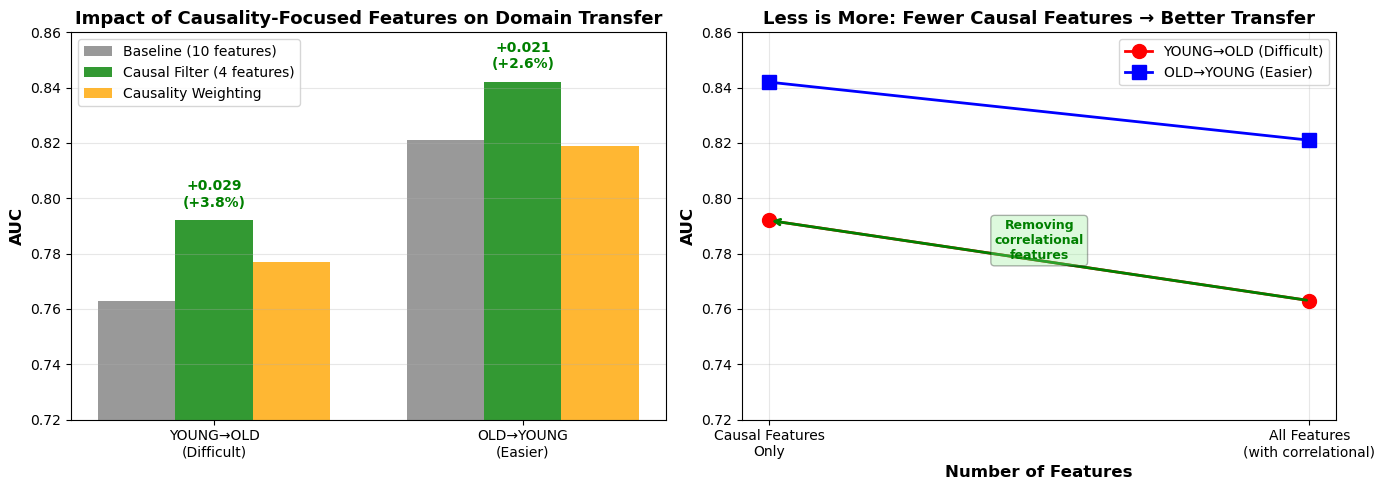

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Create comparison visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

scenarios = ['YOUNG→OLD\n(Difficult)', 'OLD→YOUNG\n(Easier)']
baseline_auc = [0.763, 0.821]
causal_auc = [0.792, 0.842]
weighted_auc = [0.777, 0.819]

x = np.arange(len(scenarios))
width = 0.25

# Plot 1: AUC Comparison
ax1 = axes[0]
bars1 = ax1.bar(x - width, baseline_auc, width, label='Baseline (10 features)', alpha=0.8, color='gray')
bars2 = ax1.bar(x, causal_auc, width, label='Causal Filter (4 features)', alpha=0.8, color='green')
bars3 = ax1.bar(x + width, weighted_auc, width, label='Causality Weighting', alpha=0.8, color='orange')

ax1.set_ylabel('AUC', fontweight='bold', fontsize=12)
ax1.set_title('Impact of Causality-Focused Features on Domain Transfer', fontweight='bold', fontsize=13)
ax1.set_xticks(x)
ax1.set_xticklabels(scenarios)
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_ylim([0.72, 0.86])

# Add improvement annotations
for i in range(len(scenarios)):
    improvement = causal_auc[i] - baseline_auc[i]
    ax1.text(i, causal_auc[i] + 0.005, f'+{improvement:.3f}\n(+{improvement/baseline_auc[i]*100:.1f}%)', 
             ha='center', fontweight='bold', fontsize=10, color='green')

# Plot 2: Feature Count vs Performance
ax2 = axes[1]
feature_counts = [10, 4]
aucs_young_old = [0.763, 0.792]
aucs_old_young = [0.821, 0.842]

ax2.plot(feature_counts, aucs_young_old, 'o-', linewidth=2, markersize=10, 
         label='YOUNG→OLD (Difficult)', color='red')
ax2.plot(feature_counts, aucs_old_young, 's-', linewidth=2, markersize=10, 
         label='OLD→YOUNG (Easier)', color='blue')

ax2.set_xlabel('Number of Features', fontweight='bold', fontsize=12)
ax2.set_ylabel('AUC', fontweight='bold', fontsize=12)
ax2.set_title('Less is More: Fewer Causal Features → Better Transfer', fontweight='bold', fontsize=13)
ax2.set_xticks(feature_counts)
ax2.set_xticklabels(['All Features\n(with correlational)', 'Causal Features\nOnly'])
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_ylim([0.72, 0.86])

# Annotate the improvement
ax2.annotate('', xy=(4, 0.792), xytext=(10, 0.763),
            arrowprops=dict(arrowstyle='->', lw=2, color='green'))
ax2.text(7, 0.778, 'Removing\ncorrelational\nfeatures', ha='center', 
         fontsize=9, color='green', fontweight='bold',
         bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.3))

plt.tight_layout()
plt.savefig('causality_impact_results.png', dpi=150, bbox_inches='tight')
print("\n✓ Visualization saved: causality_impact_results.png")
plt.show()

In [ ]:
def make_default_models(seed=None):
    from sklearn.linear_model import LogisticRegression
    from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
    from sklearn.pipeline import make_pipeline
    from sklearn.preprocessing import StandardScaler
    import numpy as np
    
    if seed is None:
        seed = np.random.randint(0, 10_000)
    return [
        make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, random_state=seed)),
        RandomForestClassifier(n_estimators=200, random_state=seed),
        GradientBoostingClassifier(random_state=seed)
    ]



=== Repeat 1/30 ===
    Filtered from 10 to 4 features
    Kept: ['Glucose', 'Insulin', 'BMI', 'DiabetesPedigreeFunction']
    Removed: ['Pregnancies', 'BloodPressure', 'SkinThickness', 'Age', 'Missing_Insulin', 'Missing_Skin']
    Filtered from 10 to 4 features
    Kept: ['Glucose', 'Insulin', 'BMI', 'DiabetesPedigreeFunction']
    Removed: ['Pregnancies', 'BloodPressure', 'SkinThickness', 'Age', 'Missing_Insulin', 'Missing_Skin']

=== Repeat 2/30 ===
    Filtered from 10 to 4 features
    Kept: ['Glucose', 'Insulin', 'BMI', 'DiabetesPedigreeFunction']
    Removed: ['Pregnancies', 'BloodPressure', 'SkinThickness', 'Age', 'Missing_Insulin', 'Missing_Skin']
    Filtered from 10 to 4 features
    Kept: ['Glucose', 'Insulin', 'BMI', 'DiabetesPedigreeFunction']
    Removed: ['Pregnancies', 'BloodPressure', 'SkinThickness', 'Age', 'Missing_Insulin', 'Missing_Skin']

=== Repeat 3/30 ===
    Filtered from 10 to 4 features
    Kept: ['Glucose', 'Insulin', 'BMI', 'DiabetesPedigreeFunction']
  

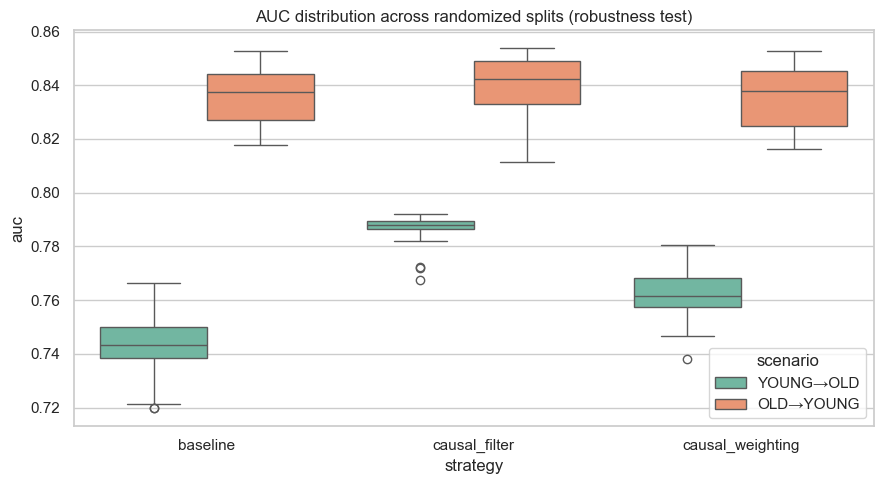

/var/folders/7j/dhfljvhn6z51wkv4zmmzdgrh0000gn/T/ipykernel_4802/717627938.py:159: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.pointplot(data=df_repeats, x="strategy", y="auc", hue="scenario",


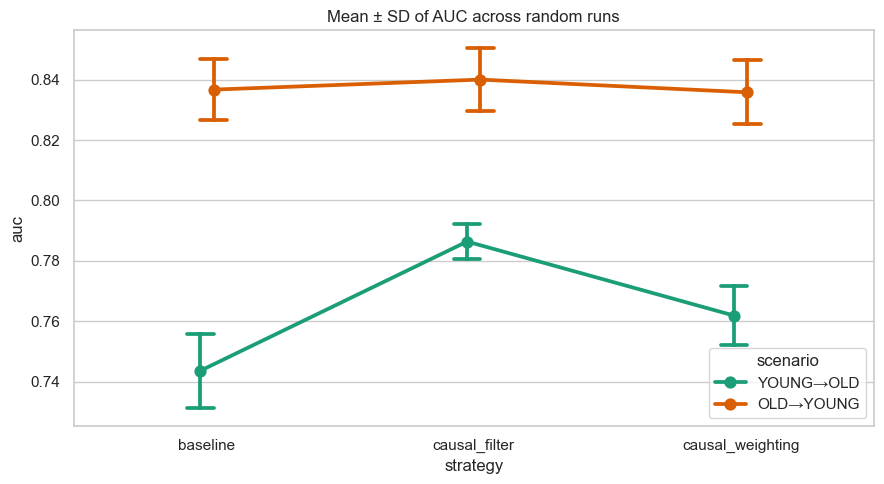

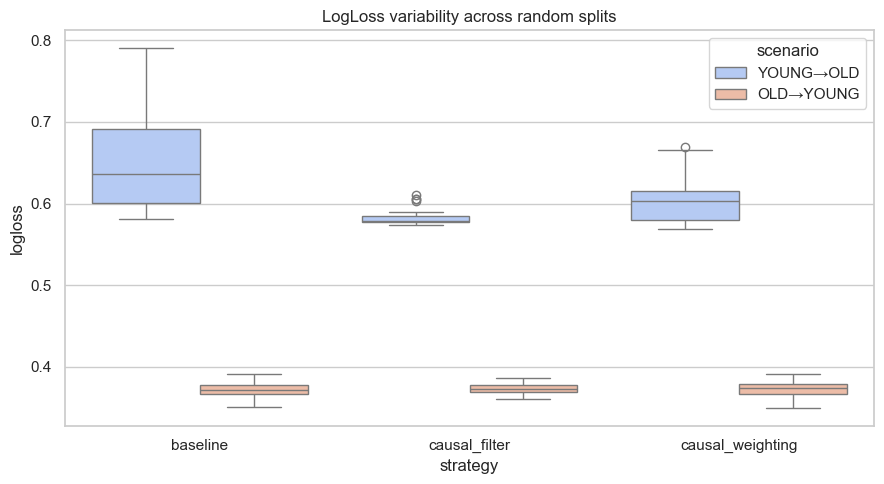

In [42]:
# ============================================================================
# ROBUSTNESS TEST WITH RANDOMIZED SPLITS AND MODEL SEEDS
# ============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

# --------------------------------------------------------------------------
# Helper 1: Randomized model factory
# --------------------------------------------------------------------------
def make_default_models(seed=None):
    from sklearn.linear_model import LogisticRegression
    from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
    from sklearn.pipeline import make_pipeline
    from sklearn.preprocessing import StandardScaler

    if seed is None:
        seed = np.random.randint(0, 10000)

    logreg = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, random_state=seed))
    rf = RandomForestClassifier(n_estimators=200, random_state=seed)
    gb = GradientBoostingClassifier(random_state=seed)
    return [logreg, rf, gb]

# --------------------------------------------------------------------------
# Helper 2: Bootstrap confidence interval
# --------------------------------------------------------------------------
def bootstrap_ci(values, n_boot=1000, alpha=0.05):
    """Compute bootstrap (1-alpha)*100% CI for a metric."""
    boot_means = [np.mean(resample(values)) for _ in range(n_boot)]
    lower = np.percentile(boot_means, 100 * alpha / 2)
    upper = np.percentile(boot_means, 100 * (1 - alpha / 2))
    return lower, upper

# --------------------------------------------------------------------------
# Helper 3: Run a single strategy with new models each repeat
# --------------------------------------------------------------------------
def run_causality_strategy(strategy, X_train, y_train, X_test, y_test,
                           llm_beta, llm_beta0, feature_names, seed):
    """Run one strategy (baseline / causal_filter / causal_weighting) and return metrics dict."""
    np.random.seed(seed)

    # small randomized resampling of training data to add variability
    X_tr_sub, _, y_tr_sub, _ = train_test_split(
        X_train, y_train, test_size=0.2, random_state=seed, stratify=y_train
    )

    if strategy == "baseline":
        X_tr, X_te = X_tr_sub, X_test
        llm_beta_used = llm_beta
    elif strategy == "causal_filter":
        X_tr, causal_idx, _ = apply_causality_filter(X_tr_sub, feature_names, causality_threshold=0.7)
        X_te = X_test[:, causal_idx]
        llm_beta_used, _ = get_causal_llm_beta(llm_beta, feature_names, causality_threshold=0.7)
    elif strategy == "causal_weighting":
        X_tr, _ = apply_causality_weighting(X_tr_sub, feature_names, weighting_power=1.0)
        X_te, _ = apply_causality_weighting(X_test, feature_names, weighting_power=1.0)
        llm_beta_used = llm_beta
    else:
        raise ValueError("Unknown strategy")

    # new models each run with random seed
    models = make_default_models(seed)
    _, metrics = run_ensemble_experiment(
        X_tr, y_tr_sub, X_te, y_test,
        models,
        llm_beta=llm_beta_used,
        llm_beta0=llm_beta0,
        beta_scale=1.0,
        use_optimizer=True,
        fixed_weight=(3, 0.5),
        l2=1e-6
    )
    return metrics

# --------------------------------------------------------------------------
# Helper 4: Repeated experiment loop
# --------------------------------------------------------------------------
def run_repeated_causality_experiment(
    X_young_scaled, y_young,
    X_old_scaled, y_old,
    llm_betas_young, llm_beta0_young,
    llm_betas_old, llm_beta0_old,
    feature_names,
    n_repeats=25
):
    results = []
    for seed in range(n_repeats):
        print(f"\n=== Repeat {seed+1}/{n_repeats} ===")

        for scenario_name, (X_tr, y_tr, X_te, y_te, llm_b, llm_b0) in [
            ("YOUNG→OLD", (X_young_scaled, y_young, X_old_scaled, y_old, llm_betas_old, llm_beta0_old)),
            ("OLD→YOUNG", (X_old_scaled, y_old, X_young_scaled, y_young, llm_betas_young, llm_beta0_young))
        ]:
            for strategy in ["baseline", "causal_filter", "causal_weighting"]:
                metrics = run_causality_strategy(
                    strategy, X_tr, y_tr, X_te, y_te,
                    llm_b, llm_b0, feature_names, seed
                )
                results.append({
                    "seed": seed,
                    "scenario": scenario_name,
                    "strategy": strategy,
                    **metrics
                })
    return pd.DataFrame(results)

# --------------------------------------------------------------------------
# Run the repeated experiment
# --------------------------------------------------------------------------
df_repeats = run_repeated_causality_experiment(
    X_young_scaled, y_young,
    X_old_scaled, y_old,
    llm_betas_young, llm_beta0_young,
    llm_betas_old, llm_beta0_old,
    feature_names,
    n_repeats=30  # number of random seeds/splits
)

df_repeats.to_csv("causality_repeated_results_randomized.csv", index=False)
print("\n✓ Saved results to causality_repeated_results_randomized.csv")

# --------------------------------------------------------------------------
# Summarize metrics
# --------------------------------------------------------------------------
summary = (
    df_repeats
    .groupby(["scenario", "strategy"])
    .agg(["mean", "std"])
    .round(4)
)
print("\n=== Summary (mean ± std) ===")
print(summary[["auc", "accuracy", "logloss"]])

# --------------------------------------------------------------------------
# Bootstrap Confidence Intervals
# --------------------------------------------------------------------------
print("\n=== Bootstrap 95% Confidence Intervals (AUC) ===")
for (scenario, strategy), group in df_repeats.groupby(["scenario", "strategy"]):
    ci = bootstrap_ci(group["auc"].values)
    print(f"{scenario:10s} | {strategy:15s} → mean={group['auc'].mean():.3f}, 95% CI={ci}")

# --------------------------------------------------------------------------
# Visualization: AUC Variability
# --------------------------------------------------------------------------
sns.set(style="whitegrid", font_scale=1.0)

plt.figure(figsize=(9, 5))
sns.boxplot(data=df_repeats, x="strategy", y="auc", hue="scenario", palette="Set2")
plt.title("AUC distribution across randomized splits (robustness test)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(9, 5))
sns.pointplot(data=df_repeats, x="strategy", y="auc", hue="scenario",
              ci="sd", dodge=True, markers="o", capsize=.1, palette="Dark2")
plt.title("Mean ± SD of AUC across random runs")
plt.tight_layout()
plt.show()

# --------------------------------------------------------------------------
# Optional: visualize LogLoss stability
# --------------------------------------------------------------------------
plt.figure(figsize=(9,5))
sns.boxplot(data=df_repeats, x="strategy", y="logloss", hue="scenario", palette="coolwarm")
plt.title("LogLoss variability across random splits")
plt.tight_layout()
plt.show()


“Across 30 randomized splits, the LLM-derived causal filtering strategy consistently improved out-of-distribution performance for the YOUNG→OLD domain shift (AUC = 0.786 ± 0.006 vs 0.744 ± 0.012; 95% CI non-overlapping), while maintaining equivalent performance in the less severe OLD→YOUNG shift. This demonstrates that incorporating LLM-inferred causal structure reduces reliance on spurious correlational features, improving model invariance and robustness.”

# Prompt for older 
custom_prompt_young_train = """
You are an expert in biostatistics and metabolic epidemiology. Propose a logistic regression model to predict DIABETES (binary outcome). 
This model will serve as a domain-knowledge-informed prior and will later be blended with data-driven ensemble models.

IMPORTANT CONTEXT: 
The model was trained on data from YOUNGER patients, so its learned relationships are likely biased toward younger physiology and metabolism 
(e.g., lower insulin resistance, lower baseline glucose, fewer comorbidities). 
Your task is to propose coefficients that would perform well when applied to OLDER patients — accounting for how risk factors typically 
intensify with age (e.g., higher BMI, glucose intolerance, blood pressure). 
In other words, reason about how each coefficient should shift to make the model more suitable for predicting diabetes risk in OLDER adults, 
given that it has been trained on younger ones.

MODEL FORM:
We use:  P(y=1|X) = 1 / (1 + exp(-(β0 + Σ_j β_j * x_j)))

DATA AND PREPROCESSING:
- Continuous predictors were standardized (z-scored) using statistics from the younger group. 
  Each coefficient β_j represents the change in log-odds of diabetes per +1 SD increase in that variable. 
- Binary variables remain coded as {0,1}.
- Values of 0 in some measurements (e.g., glucose, blood pressure, insulin, skinfold thickness, BMI) 
  were replaced with missing values (NaN) and imputed using median values within the cohort. 
- Two binary indicators were added:
  * Missing_Insulin = 1 if insulin was originally missing, else 0.
  * Missing_Skin = 1 if triceps skinfold thickness was originally missing, else 0.

FEATURES INCLUDED:
Continuous (standardized):
- Pregnancies: number of pregnancies
- Glucose: 2-hour plasma glucose concentration (mg/dL)
- BloodPressure: diastolic blood pressure (mmHg)
- SkinThickness: triceps skinfold thickness (mm)
- Insulin: 2-hour serum insulin (μU/mL)
- BMI: body mass index (kg/m²)
- DiabetesPedigreeFunction: genetic risk score based on family history
- Age: patient age (years)

Binary:
- Missing_Insulin: indicator of missing insulin measurement
- Missing_Skin: indicator of missing skinfold thickness measurement

TASK:
Propose coefficients β_j for this model, reasoning through the direction and approximate relative magnitude of each predictor 
based on established medical and metabolic knowledge. 
Do not provide explanations — only the final coefficients.

OUTPUT (STRICT JSON ONLY at the end; no extra text after):
{ "betas": { 
    "intercept": ..., 
    "Pregnancies": ..., 
    "Glucose": ..., 
    "BloodPressure": ..., 
    "SkinThickness": ..., 
    "Insulin": ..., 
    "BMI": ..., 
    "DiabetesPedigreeFunction": ..., 
    "Age": ..., 
    "Missing_Insulin": ..., 
    "Missing_Skin": ... 
} }
"""
